# This is the SQL Assignment | Bellabeat Case Study

# Load Datasets 
* dailyActivity_merged.csv
* hourlySteps_merged.csv
* minuteSleep_merged.csv
* weightLogInfo_merged.csv

In [339]:
import numpy as np
import pandas as pd
import pandasql as ps

dailyActivity = pd.read_csv("data/dailyActivity_merged.csv")

hourlySteps = pd.read_csv("data/hourlySteps_merged.csv")

sleepMinutes = pd.read_csv("data/minuteSleep_merged.csv")

weightLog = pd.read_csv("data/weightLogInfo_merged.csv")


# Preprocessing

In [340]:
# --- dailyActivity_merged ---
# convert ActivityDate to datetime 
dailyActivity['ActivityDate'] = pd.to_datetime(dailyActivity['ActivityDate'], format='%m/%d/%Y')
# drop duplicates with subset of (Id + ActivityDate)
dailyActivity = dailyActivity.drop_duplicates(subset=['Id', 'ActivityDate'])
# handle outliers by removing 0 step days 
dailyActivity = dailyActivity[dailyActivity['TotalSteps'] > 0]

# --- hourlySteps_merged ---
# convert ActivityHour to datetime (format is "MM/DD/YYYY HH:MM:SS AM/PM")
hourlySteps['ActivityHour'] = pd.to_datetime(hourlySteps['ActivityHour'], format='%m/%d/%Y %I:%M:%S %p')
# Extract hour of day 
hourlySteps['hour'] = hourlySteps['ActivityHour'].dt.hour
# Extract weekday
hourlySteps['weekday'] = hourlySteps['ActivityHour'].dt.day_name()

# --- minuteSleep_merged ---
# convert date to datetime 
sleepMinutes['date'] = pd.to_datetime(sleepMinutes['date'], errors='coerce')
# sum to total daily sleep per Id
sleep_daily = (
    sleepMinutes
    .groupby(['Id', sleepMinutes['date'].dt.date])
    .agg(TotalMinutesAsleep=('value', 'sum'))
    .reset_index()
    .rename(columns={'date': 'SleepDate'})
)
sleep_daily['SleepDate'] = pd.to_datetime(sleep_daily['SleepDate'])

# --- weightLogInfo_merged ---
# convert Date to datetime 
weightLog['Date'] = pd.to_datetime(weightLog['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
# drop unuseful columns
weightLog = weightLog[['Id', 'Date', 'WeightKg', 'BMI']]


# Check Preprocessing is done successfully

In [341]:
# Check the data types successfully converted to (datetime64)
print(dailyActivity.dtypes)
print("=========")
print(hourlySteps.dtypes)
print("=========")
print(sleep_daily.dtypes)
print("=========")
print(weightLog.dtypes)


Id                                   int64
ActivityDate                datetime64[ns]
TotalSteps                           int64
TotalDistance                      float64
TrackerDistance                    float64
LoggedActivitiesDistance           float64
VeryActiveDistance                 float64
ModeratelyActiveDistance           float64
LightActiveDistance                float64
SedentaryActiveDistance            float64
VeryActiveMinutes                    int64
FairlyActiveMinutes                  int64
LightlyActiveMinutes                 int64
SedentaryMinutes                     int64
Calories                             int64
dtype: object
Id                       int64
ActivityHour    datetime64[ns]
StepTotal                int64
hour                     int32
weekday                 object
dtype: object
Id                             int64
SleepDate             datetime64[ns]
TotalMinutesAsleep             int64
dtype: object
Id                   int64
Date        datetime

In [342]:
# Check for duplicates and outliers
# dailyActivity: duplicates
print(dailyActivity.duplicated(subset=['Id','ActivityDate']).sum())  # should be 0

# dailyActivity: 0 steps
print((dailyActivity['TotalSteps'] == 0).sum())  # should be 0

0
0


In [343]:
# Check aggregated / new columns
# hour, weekday
print(hourlySteps[['ActivityHour','hour','weekday']].head())

# SleepDate
print(sleep_daily.head())

         ActivityHour  hour   weekday
0 2016-03-12 00:00:00     0  Saturday
1 2016-03-12 01:00:00     1  Saturday
2 2016-03-12 02:00:00     2  Saturday
3 2016-03-12 03:00:00     3  Saturday
4 2016-03-12 04:00:00     4  Saturday
           Id  SleepDate  TotalMinutesAsleep
0  1503960366 2016-03-13                 441
1  1503960366 2016-03-14                 423
2  1503960366 2016-03-15                 365
3  1503960366 2016-03-16                 404
4  1503960366 2016-03-17                 473


# 5 Facts Extraction

In [344]:
# 1) User Consistency -> % of users logging activity and categorize them into Light, Moderate, Active
query_user_consistency = """
SELECT Id,
       COUNT(ActivityDate) AS DaysLogged,
       CASE 
           WHEN COUNT(ActivityDate) BETWEEN 0 AND 14 THEN 'Light User'
           WHEN COUNT(ActivityDate) BETWEEN 15 AND 24 THEN 'Moderate User'
           WHEN COUNT(ActivityDate) BETWEEN 25 AND 32 THEN 'Active User'
       END AS UserType
FROM dailyActivity
GROUP BY Id
"""

user_days = ps.sqldf(query_user_consistency, locals())
user_days.head(15)


,Id,DaysLogged,UserType
0,1503960366,19,Moderate User
1,1624580081,19,Moderate User
2,1644430081,10,Light User
3,1844505072,9,Light User
4,1927972279,12,Light User
5,2022484408,12,Light User
6,2026352035,12,Light User
7,2320127002,8,Light User
8,2347167796,14,Light User
9,2873212765,11,Light User


# Insights:
* Many users spend 700–1300 minutes/day sedentary (≈ 11–21 hours).
* being "active" doesn’t always mean Very Active workouts ,some users stay active through Light activities daily like walking/standing

In [345]:
# 2) Sedentary VS Active Lifestyle by Averaging each column and calculate total active minutes for each id
query_active_minutes = """
SELECT Id,
       AVG(VeryActiveMinutes) AS Avg_VeryActiveMinutes,
       AVG(FairlyActiveMinutes) AS Avg_FairlyActiveMinutes,
       AVG(LightlyActiveMinutes) AS Avg_LightlyActiveMinutes,
       AVG(SedentaryMinutes) AS Avg_SedentaryMinutes,
       (AVG(VeryActiveMinutes) + AVG(FairlyActiveMinutes) + AVG(LightlyActiveMinutes)) AS TotalActiveMinutes
FROM dailyActivity
GROUP BY Id
"""

active_summary = ps.sqldf(query_active_minutes, locals())
active_summary.head(15)

,Id,Avg_VeryActiveMinutes,Avg_FairlyActiveMinutes,Avg_LightlyActiveMinutes,Avg_SedentaryMinutes,TotalActiveMinutes
0,1503960366,35.842105,15.842105,228.210526,809.842105,279.894737
1,1624580081,0.736842,0.578947,121.052632,1278.315789,122.368421
2,1644430081,14.800000,43.500000,227.700000,1034.200000,286.000000
3,1844505072,1.000000,1.000000,211.333333,1098.777778,213.333333
4,1927972279,0.000000,1.666667,111.666667,952.916667,113.333333
5,2022484408,40.083333,22.500000,253.833333,1058.916667,316.416667
6,2026352035,0.000000,0.000000,169.333333,659.166667,169.333333
7,2320127002,1.375000,1.625000,188.875000,1153.875000,191.875000
8,2347167796,12.642857,24.785714,271.642857,702.357143,309.071429
9,2873212765,5.545455,6.545455,300.272727,1109.363636,312.363636


In [346]:
# 3) Steps Distribution for each Hour
query_steps_hourly = """
SELECT hour,
       SUM(StepTotal) AS TotalSteps
FROM hourlySteps
GROUP BY hour
ORDER BY TotalSteps DESC
"""

steps_hourly_top5 = ps.sqldf(query_steps_hourly, locals())
steps_hourly_top5.head()


,hour,TotalSteps
0,19,525176
1,12,518861
2,18,502107
3,14,472228
4,13,456051


# Insights: 
* Users who sleep 6–8 hours have the highest average steps (~8927)
* Users sleeping more than 10 hours have the lowest average steps (~5973)

In [347]:
# 4) Sleep VS Activity

# Join daily activity with sleep to prepare daily_sleep_activity
query_sleep_activity = """
SELECT a.Id,
       a.ActivityDate,
       a.TotalSteps,
       s.TotalMinutesAsleep
FROM dailyActivity a
INNER JOIN sleep_daily s
ON a.Id = s.Id AND a.ActivityDate = s.SleepDate
"""

daily_sleep_activity = ps.sqldf(query_sleep_activity, locals())

# Categorize sleep ranges and compute average steps ---
query_sleep_ranges = """
SELECT CASE 
           WHEN TotalMinutesAsleep <= 300 THEN '0-5hr'
           WHEN TotalMinutesAsleep <= 360 THEN '5-6hr'
           WHEN TotalMinutesAsleep <= 480 THEN '6-8hr'
           WHEN TotalMinutesAsleep <= 600 THEN '8-10hr'
           ELSE '>10hr'
       END AS SleepRange,
       AVG(TotalSteps) AS AvgSteps
FROM daily_sleep_activity
GROUP BY SleepRange
ORDER BY SleepRange
"""

sleep_activity_summary = ps.sqldf(query_sleep_ranges, locals())
sleep_activity_summary


,SleepRange,AvgSteps
0,0-5hr,7840.608696
1,5-6hr,8438.500000
2,6-8hr,8926.716418
3,8-10hr,7827.549296
4,>10hr,5972.962963


In [ ]:
# 5) BMI & Weight Trends
# Get weight min, max, avg per user using SQL
query_weight_trends = """
SELECT Id,
       COUNT(*) AS LogCount,
       ROUND(MIN(WeightKg),2) AS MinWeight,
       ROUND(MAX(WeightKg),2) AS MaxWeight,
       ROUND(MAX(WeightKg) - MIN(WeightKg),2) AS WeightChange,
       ROUND(AVG(WeightKg),2) AS AvgWeight,
       ROUND(AVG(BMI),2) AS AvgBMI
FROM weightLog
GROUP BY Id
HAVING LogCount > 1
ORDER BY WeightChange DESC
"""

weight_trends = ps.sqldf(query_weight_trends, locals())
weight_trends.head() # note it gives only 3 rows because this dataset'weightLogInfo_merged.csv' is small and only 3 ids are repeated more than 1 time (HAVING LogCount > 1)


,Id,LogCount,MinWeight,MaxWeight,WeightChange,AvgWeight,AvgBMI
0,8877689391,9,85.0,86.6,1.6,85.76,25.68
1,6962181067,14,60.9,62.5,1.6,61.86,24.16
2,2873212765,2,56.7,57.2,0.5,56.95,21.55


# Visualization for some Facts

C:\Users\fxrxh\AppData\Local\Temp\ipykernel_23016\371029717.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=user_type_counts.index, y=user_type_counts.values, palette='viridis')


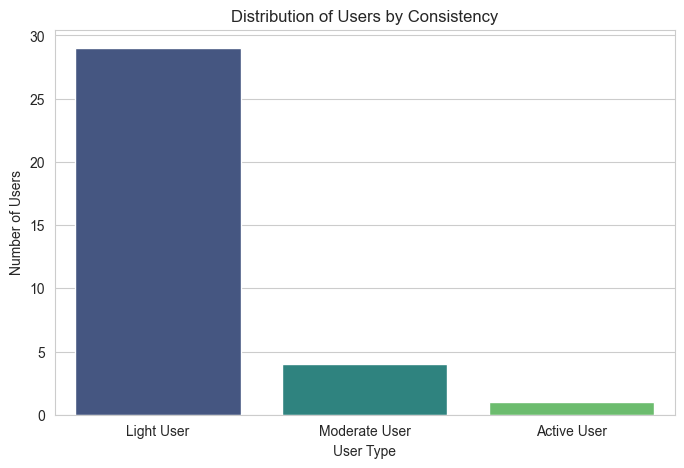

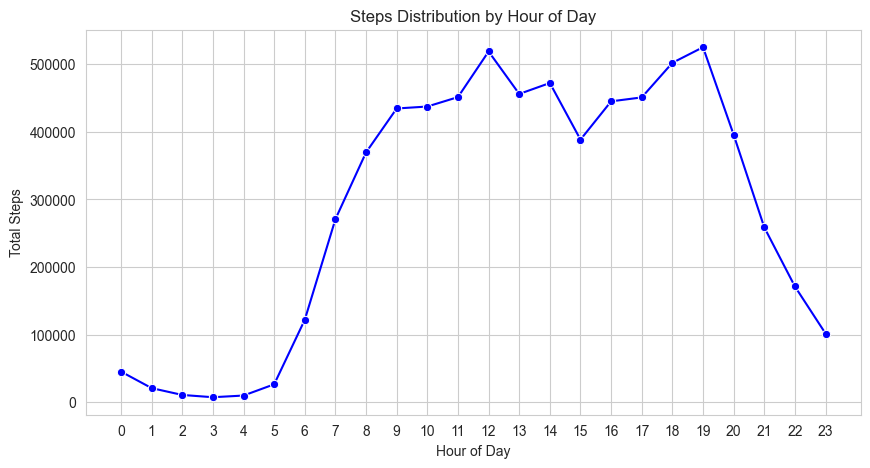

C:\Users\fxrxh\AppData\Local\Temp\ipykernel_23016\371029717.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SleepRange', y='AvgSteps', data=sleep_activity_summary, palette='coolwarm')


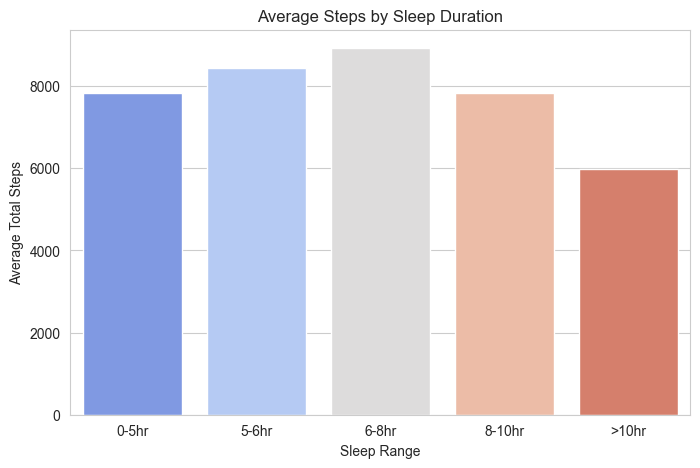

In [353]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

# --- 1) User Consistency ---
plt.figure(figsize=(8,5))
user_type_counts = user_days['UserType'].value_counts()
sns.barplot(x=user_type_counts.index, y=user_type_counts.values, palette='viridis')
plt.title("Distribution of Users by Consistency")
plt.ylabel("Number of Users")
plt.xlabel("User Type")
plt.show()

# --- 3) Steps Distribution per Hour ---
plt.figure(figsize=(10,5))
sns.lineplot(x='hour', y='TotalSteps', data=steps_hourly_top5, marker='o', color='blue')
plt.title("Steps Distribution by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Total Steps")
plt.xticks(range(0,24))
plt.grid(True)
plt.show()


# --- 4) Sleep vs Activity ---
plt.figure(figsize=(8,5))
sns.barplot(x='SleepRange', y='AvgSteps', data=sleep_activity_summary, palette='coolwarm')
plt.title("Average Steps by Sleep Duration")
plt.xlabel("Sleep Range")
plt.ylabel("Average Total Steps")
plt.show()

